In [6]:
import os

import torch
from torch import nn

from core.models import VAE, Diffusion
from core.schedulers import NoiseScheduler

checkpoint_folder = "./checkpoints/first_attempt"

# 1. Instantiate and load the models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# VAE
vae = VAE(
    input_shape=(1, 64, 64),
    config_file="./MNIST_VAE.yaml"
).to(device)

if os.path.exists(os.path.join(checkpoint_folder, "VAE", "vae.pth")):
    checkpoint = torch.load(os.path.join(checkpoint_folder, "VAE", "vae.pth"), map_location=device)
    vae.load_state_dict(checkpoint['model_state_dict'])

    best_loss = checkpoint.get('best_loss', float('inf'))
    seed = checkpoint.get('seed', None)
    start_epoch = checkpoint.get('epoch', 0) + 1

    print(f"[INFO] Resumed VAE training from epoch {start_epoch} with best loss {best_loss:.4f}.\n")
else:
    print("[INFO] No VAE checkpoint found. Consider using the training script to train the VAE first.")

# Diffusion
diffusion = Diffusion(
    latent_dim=vae.latent_dim,
    config_file="./MNIST_UNet.yaml"
).to(device)

noise_scheduler = NoiseScheduler(
    steps=1000,
    betas=(1e-4, 0.02),
    schedule='cosine',
    seed=seed
)

if os.path.exists(os.path.join(checkpoint_folder, "diffusion", "diffusion.pth")):
    checkpoint = torch.load(os.path.join(checkpoint_folder, "diffusion", "diffusion.pth"), map_location=device)
    diffusion.load_state_dict(checkpoint['model_state_dict'])
    noise_scheduler.load_state_dict(checkpoint['noise_scheduler_state_dict'])

    best_loss = checkpoint.get('best_loss', float('inf'))
    start_epoch = checkpoint.get('epoch', 0) + 1

    print(f"[INFO] Resumed Diffusion training from epoch {start_epoch} with best loss {best_loss:.4f}.\n")
else:
    print("[INFO] No Diffusion checkpoint found. Consider using the training script to train the Diffusion model first.")

[INFO] No VAE checkpoint found. Consider using the training script to train the VAE first.
[INFO] No Diffusion checkpoint found. Consider using the training script to train the Diffusion model first.


In [ ]:
from core.samplers import DDPMSampler

# 2. Sample from the Diffusion model using DDPM

sampler = DDPMSampler(noise_scheduler=noise_scheduler).to(device)

context = torch.zeros((1, 1, 128), device=device)

x = torch.randn((1, *vae.latent_shape), device=device)
sampled_latent = sampler.sample(
    x=x,
    pred_noise_func=diffusion,
    func_inputs={'context': context},
    return_intermediates=True,
    return_step=100
)

Sampling: 100%|██████████| 1000/1000 [00:13<00:00, 71.79it/s]


In [ ]:
from core.samplers import DDIMSampler

# 2. Sample from the Diffusion model using DDIM

sampler = DDIMSampler(
    noise_scheduler=noise_scheduler, 
    steps=50,
    eta=0.0
).to(device)

context = torch.zeros((1, 1, 128), device=device)

x = torch.randn((1, *vae.latent_shape), device=device)
sampled_latent = sampler.sample(
    x=x,
    pred_noise_func=diffusion,
    func_inputs={'context': context},
    return_intermediates=True,
    return_step=5
)

Sampling: 100%|██████████| 50/50 [00:00<00:00, 71.40it/s]


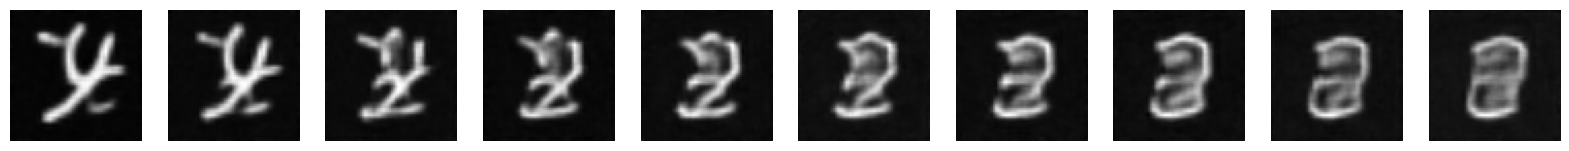

In [5]:
# 3. Decode the sampled latent representation using the VAE

sampled_latent = torch.cat(sampled_latent, dim=0)
with torch.no_grad():
    sampled_image = vae.decoder(sampled_latent, rescale=True)

# 4. Plot the sampled image

import matplotlib.pyplot as plt

num_samples = sampled_image.shape[0]

fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 2, 2))
for i in range(num_samples):
    axes[i].imshow(sampled_image[i, 0].cpu().numpy(), cmap='gray')
    axes[i].axis('off')